## PD Controller: An Introduction

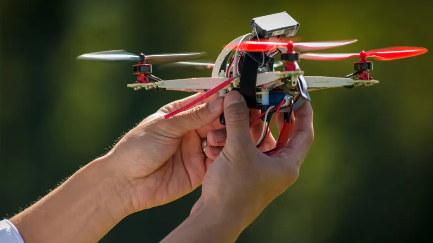

Control system is an importact sector in engineering designs. For example, if we want to build an unmanned aerial vehicle (UAV), we may hope that the UAV can travel along some pre-defined path. Or, if we are to build an air conditioning system, we may hope that the heating or cooling system can operate at the right settings so that the temperature of the environment is maintained at a comfortable value. However, in practice, it may happen that the UAV has somewhat deviated from its desired course, or the temperature of the room is a bit too high or too low. Our problem is how we can design a control system to correct for such errors and help the system get on the right track?

A sketchy scheme may be outlined as follows: we can first measure the parameters of the system in real time with all sorts of sensors. These parameters are compared with the reference values, so that the errors are computed. Based on the errors, we can adjust the output of the engineering system (power output of the UAV or the heating/cooling components), so that the error gets reduced. To briefly wrap up, the entire control loop contains three major parts:

- Sensors: collecting real time data that quantify what is going on
- Controller: making decision on what to do based on the error
- Output devices: making response to what the controller tells them to do

In this notebook, we are going to investigate a type of controller known as the **PD controller**. A PD controller consists of two key parts: a **P**roportional unit and a **D**erivative unit. The control mechanism is basically the sum of the proportional algorithm and the derivative algorithm, hence it is called a PD controller.

## Principles

Let's take the problem of path control for an UAV. To make things easier, let's consider the motion in one dimension only, which we take to be the vertical direction $(z)$. In particular, we may hope that the UAV can reach a certain height as quickly as possible.

The desired height for the UAV can be a function of time $t$, denoted by $z_\text{des}(t)$, where the label 'des' comes from the word 'desired'.

The real height at time $t$ as measured by the sensors is $z(t)$. We can then introduce the **error function**:

$$ e(t) = z_\text{des}(t) - z(t) \tag{1}$$

The control problem can be now rephrased as: what are the corresponding output response to make $e(t)$ quickly decrease to zero?

### Analogy with the damped mass-spring oscillator

Let's recap a bit about our previous studies about the damped oscillator. Under the influence of the restoring force exerted by the spring, the mass block tends to accelerate towards the equilibrium position no matter where its initial position is. When resistive forces kick in, the amplitude of the oscillation decreases with time, eventually tending to zero. In other words, the combined effect of the restoring force from the spring and the resistive force shall cause the displacement of the oscillator to vanish.

Does this sound like the controller problem we are working on?

In a typical mass-spring system, the restoring force obeys Hooke's law $T = kx$, and the resistive force can be assumed to be in proportion to the speed of the mass: $f = \alpha \dot{x}$, so the equation of motion can be written as:

$$ m\ddot{x} = -kx - \alpha \dot{x} $$

where I have used the dot notation for time derivative: a single dot represents the first time derivative and the double dot represents a second derivative. The minus signs are due to the fact that restoring force always acts in opposite direction to the displacement, and resistive force always acts in opposite direction to the velocity. This equation can be massaged into a simpler form:

$$ \ddot{x} + B\dot{x} +Cx = 0 \qquad \text{with } B=\frac{\alpha}{m}, C = \frac{k}{m} $$

Up to this point, we can think of $B$ and $C$ as some positive constants. It can be shown that the displacement $x$ will always tend to zero for all positive values of $B$ and $C$.

If $B^2 < 4C$, then $x(t)$ will fluctuate above and below zero with a gradually decreasing amplitude, eventually converging to zero. This looks like the behaviour of a *lightly-damped* oscillator.

If $B^2 > 4C$, then $x(t)$ will drop to zero exponentially, mimicking a *heavily-damped* oscillator.

### The PD controller model

Getting back to the controller problem. Now, if we can manipulate the output power for the UAV tailered to our goal, such that the error function satisfies:

$$ \ddot{e} + K_d \dot{e} + K_p e = 0 \tag{2}$$

then the difference between the actual path and the desired path should also drop to zero. Because the $K_p$ term and the $K_d$ term are proportional to the error function and the derivative of the error function respectively, so the two parameters are called the **proportional gain** and the **derivative gain**.

Plugging (1) into (2), we find:

$$ \ddot{z}_\text{des} -\ddot{z} + K_d (\dot{z}_\text{des} - \dot{z}) + K_p (z_\text{des} - z) = 0 $$

${z}_\text{des}$, $\dot{z}_\text{des}$ and $\ddot{z}_\text{des}$ all depend on the pre-designed path, i.e., they are all known functions of time.  $z$ and $\dot{z}$ can be monitored in real time by the motion sensors,  so the only thing that is to be determined is $\ddot{z}$, the acceleration of the UAV. It is straightforward to rearrange to find:

$$ \ddot{z} = \ddot{z}_\text{des} + K_d (\dot{z}_\text{des} - \dot{z}) + K_p (z_\text{des} - z) = 0 \tag{3}$$

Since acceleration $\ddot{z}$ is closely tied to the output of the UAV, the controller can calculate the appropriate value for $\ddot{z}$ at ant instant according to (3), based on which the output actuators do their job. As a result, the error between the actual position and the pre-defined location is minimised.

The rate at which $e(t)$ drops to zero is dependent on the choices of the values for $K_p$ and $K_d$. In practice, we can test a whole range of combinations of $K_p$ and $K_d$ and find out the optimal solution.

## Simulation & Tests

We use Python codes to implement the PD controller algorithm. Some comments are added to the codes to help understanding.

Since we do not have the sensor data to track the motion of the UAV, we will use numerical methods to predict the position and the velocity of the UAV based on the history of the motion. In particular, we use the Euler method to extrapolate $z(t+\Delta t)$ and $\dot{z}(t+\Delta t)$ from our knowledge about the motion at time $t$. The details of the implementation can be checked in the codes.

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# define constant parameters
t_step = 0.01      # time steps
n_iter = 640       # number of time steps to run
total_time = n_iter * t_step

# set up initial conditions
# initially at rest at ground level (zero speed, zero height)
z0, z_dot0, z_dotdot0 = 0, 0, 0

In [3]:
def controller(Kp, Kd, func):
    # main code: defines the 1D PD controller
    # require paremeters: Kp, Kd, and the desired trajectory 'func'
    # func: a Python function that returns the desired height at different times
    
    t = np.arange(0, total_time, t_step)

    # setting up the arrays to store desired trajectory and actual trajectory
    z, z_dot, z_dotdot = np.zeros(n_iter), np.zeros(n_iter), np.zeros(n_iter)
    z_des, z_dot_des, z_dotdot_des = np.zeros(n_iter), np.zeros(n_iter), np.zeros(n_iter)

    # setting up the initial values for actual trajectory
    z[0], z_dot[0], z_dotdot[0] = z0, z_dot0, z_dotdot0

    # error = desired trajectory - actual trajectory
    # the goal is to let the error decrease to zero quickly
    # this allows us to determine the acceleration at any time instant
    for i in range(1, n_iter):
        # getting values for the desired path
        z_des[i], z_dot_des[i], z_dotdot_des[i] = func(i*t_step)
        # using Euler method to extrapolate the new height and new velocity
        z[i] = z[i-1] + z_dot[i-1] * t_step
        z_dot[i] = z_dot[i-1] + z_dotdot[i-1] * t_step
        # finding the desired acceleration with PD controller algorithm
        z_dotdot[i] = z_dotdot_des[i] + Kd * (z_dot_des[i] - z_dot[i]) + Kp * (z_des[i] - z[i])

    fig, ax = plt.subplots()
    line1 = ax.plot(t, z_des, label='Desired Trajectory')
    line2 = ax.plot(t, z, label='Actural Trajectory')
    ax.legend()
    plt.ylabel('Height (metres)')
    plt.xlabel('Time (seconds)')
    plt.rcParams["figure.figsize"] = (10, 6)
    plt.show()

### Simplest possible test: hovering at a fixed height

The UAV is supposed to rise to a certain height and then hover at that height.

This simple test allows us to test the effects of different values of $K_p$ and $K_d$.

In [4]:
# simulation: rise to a given height and hover
def const_height_traj(t):
    return [2, 0, 0]

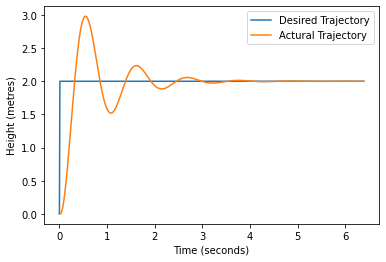

In [5]:
# large Kp / low Kd case
# quadrotor can rise to desired height very quickly, but it would overshoot
# quadrotor would oscillate about the desired height before settling down
Kp = 36
Kd = 3

controller(Kp, Kd, const_height_traj)

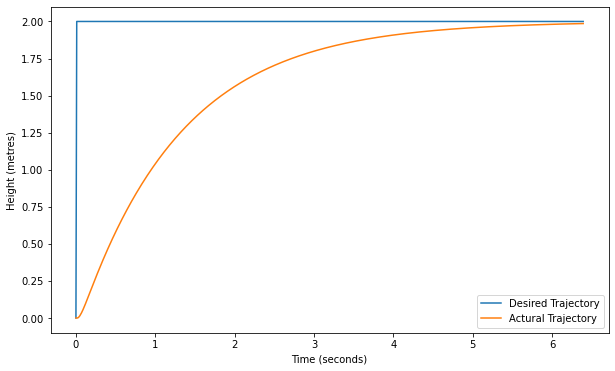

In [6]:
# low Kp / high Kd case
# quadrotor would not overshoot, but it takes long time to reach desired position
Kp = 15
Kd = 20

controller(Kp, Kd, const_height_traj)

A large value for $K_p$ and a small value for $K_d$ lead to an oscillatory pattern. The UAV does rise to the desired height very quickly, but the side effect is that the UAV will *overshoot*. This is analogous to a mass-spring system with a very strong spring but a relatively small resistance: the mass can start off and rush towards the equilibrium position very quickly, but it cannot slow down sufficiently so it would move beyond the origin and get to the other side, followed by further back and forth oscillations. The amplitude of such oscillations will decrease to practically zero, but the stability of the path control is clearly no good.

If, on the other hand, we choose a small value for $K_p$ and a large value for $K_d$, then it turns out that the UAV reaches the desired height without overshooting, but at the cost of a much longer time to do so. This looks like a mass-spring system with a weak spring but a lot of resistance. If you use only a tiny force to pull the mass back towards the equilibrium position when strong resistive effects are present, what you can do is to make the mass slowly struggle its way to the origin. There is good stability, but one has to wait so long to correct for the error, so this is not a good controller either.

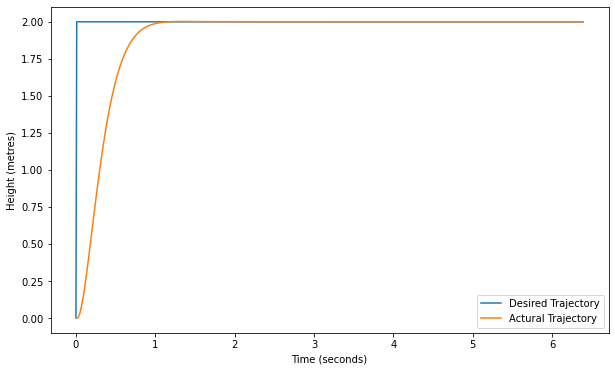

In [7]:
# a better choice of Kp and Kd
# you can change these values and compare the outcomes
Kp = 30
Kd = 10
controller(Kp, Kd, const_height_traj)

The best choice of $K_p$ and $K_d$ is comprise of both. There are mathematical techniques to derive the optimal values, but we can simply search for the optimal solutions by trial and error.

Here we have a nice test result. The UAV rises to the preset height in merely one second and then happily sits there without going up and down, exactly what hope for.

We can further take the same set of $K_p$ and $K_d$ values and see whether they are competent for other trajectories.

In [8]:
# your choice of Kp and Kd for futher tests
# you can change these values and compare the outcomes
Kp = 30
Kd = 10

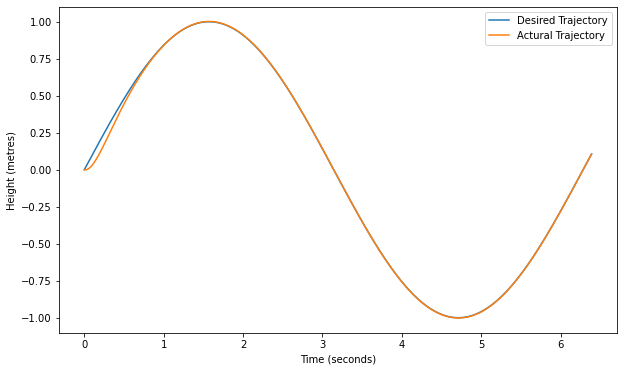

In [9]:
# simulation: a sine curve trajectory
def sine_traj(t):
    z_des = np.sin(t)
    z_dot_des = np.cos(t)
    z_dotdot_des = -np.sin(t)
    return [z_des, z_dot_des, z_dotdot_des]

# test the effects of the controller
controller(Kp, Kd, sine_traj)

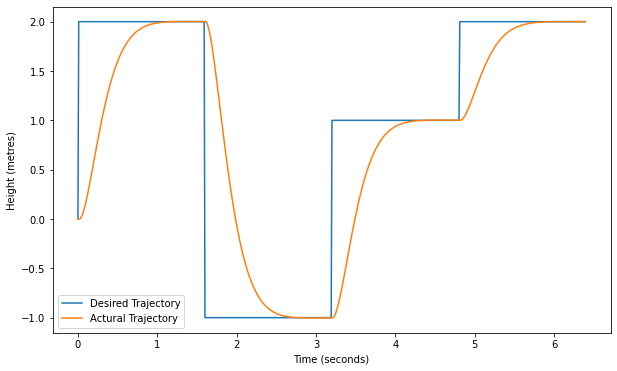

In [10]:
# simulation: jumping and hovering at a series of heights
def step_jump_traj(t):
    if t < total_time * 0.25:
        return [2, 0, 0]
    elif t < total_time * 0.5:
        return [-1, 0, 0]
    elif t < total_time * 0.75:
        return [1, 0, 0]
    else:
        return [2, 0, 0]

controller(Kp, Kd, step_jump_traj)

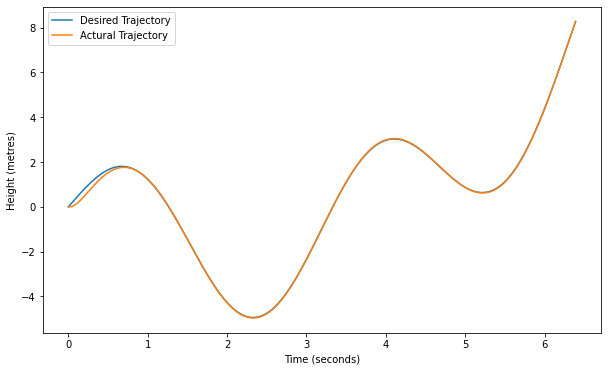

In [11]:
# simulation: motion along some awkward curve
def awkward_traj(t):
    z_des = 0.5 * t**2 - 2 * t + 3 * np.sin(2*t)
    z_dot_des = t - 2 + 6 * np.cos(2*t)
    z_dotdot_des = 1 - 12 * np.sin(2*t)
    return [z_des, z_dot_des, z_dotdot_des]

controller(Kp, Kd, awkward_traj)

### Exercises & Problems

1. Change the settings for $K_p$ and $K_d$. Run the tests for each of the preset trajectories. Comment on the performance of the PD controller.

2. Define some new trajectory $z^\text{des}(t)$ for testing (polynomials, logarithmicl functions, hyperbolic functions, etc., you name it!). Make reference to the codes in the notebook, convert your mathematical function for $z^\text{des}(t)$ and the associated the time derivatives to a Python function. Run the tests and comment on the outcomes.

3. Can you generalise the methods we developed so far to design a temperature control system? Can you come up with any other scenarios that a PD controller can be applied?

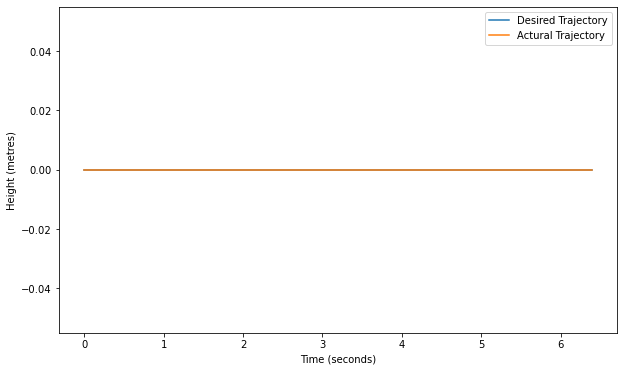

In [12]:
# your simulation
def DIY_traj(t):
    z_des = 0
    z_dot_des = 0
    z_dotdot_des = 0
    return [z_des, z_dot_des, z_dotdot_des]

Kp = 0
Kd = 0
controller(Kp, Kd, DIY_traj)